## Luria Delbruck Spontaneous Mutations

In [32]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
from scipy.special import comb, factorial
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d
from scipy.special import betainc

np.random.seed(123)

def deterministic_growth_population(initial_population, initial_time, max_time, growth_rate):
    """
    The population of sensitive bacterial cells at the end time.
    
    Parameters:
    max_time: End time of the simulation.
    initial_population: Initial population size.
    growth_rate: Growth rate per individual.
    
    Returns:
    the total populations at the end time.
    """
    
    # sensitive cells grow exponentially
    return initial_population * np.exp(growth_rate*max_time)

def yule_process(initial_population, initial_time, max_time, growth_rate):
    """
    The growth of mutants populations 
    from initial time until end time by Yule process.
    
    Parameters:
    max_time: End time of the simulation.
    initial_population: Initial population size.
    growth_rate: Growth rate per individual.
    
    Returns:
    times: a list of time.
    population:  a list of populations.
    """
    
    time = initial_time
    population = initial_population
    times = [initial_time]
    populations = [initial_population]
    
    while time < max_time:
        
        # generate random time with rate n*cell division rate
        next_time = np.random.exponential(1 / (population * growth_rate))
        
        # population increase by 1
        time += next_time
        population += 1
        
        times.append(time)
        populations.append(population)
        
    return times, populations

def cumulative_intensity(t, initial_population, mutation_rate, growth_rate):
    """
    Parameters:
    t: Time.
    initial_population: Initial population size.
    growth_rate: Growth rate per individual.
    
    Returns:
    Cumulative intensity (integral of intensity function from 0 to t).
    """
    
    # Cumulative intensity is the integral of mutation_rate * initial_population * exp(growth_rate * u) du from 0 to t
    return (mutation_rate * initial_population / growth_rate) * (np.exp(growth_rate * t) - 1)

def generate_mutation_events(end_time, initial_population, growth_rate, mutation_rate):
    """
    Generate a list of time that mutation occurs.
    
    Parameters:
    end_time: The time at which to stop generating mutation events.
    initial_population: The initial population size.
    growth_rate: The growth rate of the population.
    mutation_rate: Mutation rate per bacterium per unit time.
    
    Returns:
    A list of mutation event times.
    """
    mutation_events = []
    current_time = 0
    
    while current_time < end_time:
        
        U = np.random.uniform(0, 1)
            
        # Solve for the next event time using the inverse transform method
        # Find time t such that cumulative_intensity(t) = cumulative_intensity(current_time) + log(1/U)
        current_intensity = cumulative_intensity(current_time, initial_population, mutation_rate, growth_rate)
        target_intensity = current_intensity + np.log(1/U)
        
        # Solve for the next time using the inverse of the cumulative intensity
        next_time = (1 / growth_rate) * np.log((growth_rate * target_intensity / (mutation_rate * initial_population)) + 1)
        
        if next_time <= end_time:
            mutation_events.append(next_time)
        
        current_time = next_time
    
    return mutation_events

def yule_process_with_mutations(end_time, initial_population, growth_rate, mutation_rate):
    """
    Mutants that occurs at set of mutation event growth with Yule process
    
    Parameters:
    end_time: The time at which to evaluate the population.
    initial_population: The initial population size.
    growth_rate: The growth rate of the population.
    mutation_rate: Mutation rate per bacterium per unit time.
    
    Returns:
    final_population: Total number of sensitve bacterial populations.
    total_mutant_population: Total number of mutant populations.
    mutation_events: A list of mutation event times.
    """
    # Calculate final population at the end time for original population
    population_at_t = deterministic_growth_population(initial_population, 0, end_time, growth_rate)
    final_population = population_at_t
    
    # Generate mutation events using the continuous-time inverse transform method
    mutation_events = generate_mutation_events(end_time, initial_population, growth_rate, mutation_rate)
    
    # Simulate the growth of mutants initiated at mutation events
    total_mutant_population = 0
    for mutation_time in mutation_events:
        
        # Calculate the mutant population at the end time using Yule process
        time_mutant, pop_mutant = yule_process(initial_population, mutation_time, end_time, growth_rate)
        mutant_final_population = pop_mutant[-1]
        total_mutant_population += mutant_final_population
    
    return final_population, total_mutant_population, mutation_events

def run_simulations(num_simulations, end_time, initial_population, growth_rate, mutation_rate):
    """
    Parameters:
    num_simulations: The number of simulations to run.
    end_time: The time at which to evaluate the population.
    initial_population: The initial population size.
    growth_rate: The growth rate of the population.
    mutation_rate: Mutation rate per bacterium per unit time.
    
    Returns:
    expected_mutant_population: Expected number of total mutant populations.
    variance_mutant_population: Variance number of total mutant populations.
    p0: Probability that no mutations have occured over time.
    expected_population: Expected number of sensitive bacterial populations.
    mutant_populations: List of number of total mutant populations for all simulations.
    final_populations: List of number of sensitive bacterial populations for all simulations.
    """
    final_populations = []
    mutant_populations = []
    mut_event = []
    no_mutation = 0
    
    for _ in tqdm(range(num_simulations), desc="Running simulations"):
        final_population, total_mutant_population, mutation_events = yule_process_with_mutations(
            end_time, initial_population, growth_rate, mutation_rate)
        
        final_populations.append(final_population)
        mutant_populations.append(total_mutant_population)
        mut_event.append(len(mutation_events))
        
        # a simulation with no mutants
        if total_mutant_population == 0:
            no_mutation += 1
    
    expected_mutant_population = np.mean(mutant_populations)
    variance_mutant_population = np.var(mutant_populations)
    p0 = no_mutation/num_simulations
    expected_population = np.mean(final_populations)
    
    return expected_mutant_population, variance_mutant_population, p0, expected_population, mutant_populations, final_populations

/Users/mig/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [55]:
if __name__ == "__main__":
    end_time = 8
    initial_population = 1
    growth_rate = 1
    mutation_rate = 0.0001
    num_simulations = 100000

    expected_mutant_population, variance_mutant_population, p0, expected_population, mutant_populations, final_populations = run_simulations(
        num_simulations, end_time, initial_population, growth_rate, mutation_rate)

print('expected mutants = ', expected_mutant_population)
print('variance of mutants = ', variance_mutant_population)


Running simulations: 100%|███████████| 100000/100000 [00:01<00:00, 81593.70it/s]

expected mutants =  2.83977
variance of mutants =  2613.7250163471003


#### Expected value and variance of the number of mutant populations from Mathematical model

In [56]:
def theory_expected_mutant(mutation_rate, growth_rate, end_time):
    """
    The expected number of mutant population from Luria and Delbruck's Legacy.
    
    Parameters:
    end_time: The time at which to stop generating mutation events.
    growth_rate: The growth rate of the population.
    mutation_rate: Mutation rate per bacterium per unit time.
    
    Returns:
    Expected number of mutant population from Luria and Delbruck's Legacy.
    """
    return mutation_rate * end_time * np.exp(growth_rate * end_time)

def theory_var_mutant(mutation_rate, growth_rate, end_time):
    """
    The variance of mutant population from Luria and Delbruck's Legacy.
    
    Parameters:
    end_time: The time at which to stop generating mutation events.
    growth_rate: The growth rate of the population.
    mutation_rate: Mutation rate per bacterium per unit time.
    
    Returns:
    Variance of mutant population from Luria and Delbruck's Legacy.
    """
    return (((mutation_rate * np.exp(growth_rate * end_time)) / growth_rate) * (2 * np.exp(growth_rate * end_time) - growth_rate * end_time - 2))

In [57]:
print('expected mutants = ', theory_expected_mutant(mutation_rate, growth_rate, end_time))
print('variance of mutants = ', theory_var_mutant(mutation_rate, growth_rate, end_time))

expected mutants =  2.384766389633383
variance of mutants =  1774.241146114533


### Estimating mutation rate

#### poisson approximation method ($p_0$)

In [58]:
def mutation_rate_p0(growth_rate, p0, expected_population):
    """
    Estimating mutation rate from poisson approximation (p0)
    
    Parameters:
    p0: fraction of number of cultures with no mutation.
    growth_rate: The growth rate of the population.
    expected_population: Total population for bacteria.
    
    Return: mutation rate from poisson approximation (p0)
    """
    return -growth_rate*np.log(p0)/expected_population

In [59]:
print('Estimating mutation rate from poisson approximation (p0) = ', mutation_rate_p0(growth_rate, p0, expected_population))

Estimating mutation rate from poisson approximation (p0) =  0.00010045690109231654


#### Drake's equation

In [60]:
def mutation_rate_drake_equation(expected_population, mutant_population, growth_rate):
    """
    Estimating mutation rate from Drake's equation
    
    Parameters:
    expected_population: Total population for bacteria.
    mutant_population: Total population of mutants.
    growth_rate: The growth rate of the population.
    
    Return: mutation rate from Drake's equation
    """
    
    # the fraction of mutants and the sensitive cells
    f = np.mean(mutant_population)/expected_population
    
    return growth_rate*f/np.log(np.mean(expected_population))

In [61]:
print('Estimating mutation rate from Drakes equation = ', mutation_rate_drake_equation(expected_population, expected_mutant_population, growth_rate))

Estimating mutation rate from Drakes equation =  0.00011907958835483951


#### Maximum Likelihood Method - Proportion of Cultures with Mutants

In [62]:
def mutation_rate_ML1(expected_population, mutant_population, num_simulations):
    """
    Estimating mutation rate from Maximum Likelihood Method 
    Proportion of Cultures with Mutants
    
    Parameters:
    expected_population: Total population for bacteria.
    mutant_population: Total population of mutants.
    num_simulations: Number of simulations.
    
    Return: mutation rate from Maximum Likelihood Method 
    Proportion of Cultures with Mutants
    """
    X = 0
    # count number of simultaions with no mutation
    for k in mutant_population:
        if k == 0:
            X += 1
    N = expected_population
    C = num_simulations

    return -np.log(X/C)/N

In [63]:
print('Estimating mutation rate from Maximum Likelihood Method - Proportion of Cultures with Mutants = ', mutation_rate_ML1(expected_population, mutant_populations, num_simulations))

Estimating mutation rate from Maximum Likelihood Method - Proportion of Cultures with Mutants =  0.00010045690109231654


#### Maximum Likelihood Method - Full Mutant Distribution 

We vary the mutation rate and plot the relative error.
We choose 2000 as the upper bound for the mutant population.

Running simulations: 100%|█████████████████| 5000/5000 [00:10<00:00, 471.49it/s]
/var/folders/s3/bs4t_w8j12j88rywpg85yqr40000gn/T/ipykernel_13912/2971797521.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pmf_func[0] = math.exp(m)
/var/folders/s3/bs4t_w8j12j88rywpg85yqr40000gn/T/ipykernel_13912/2971797521.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pmf_func[k] = sum


260220812.85568535
260220812.69327253
362348118.3336986
362348118.3336986
230305184.0156671
230305183.8514103
126614404.6563562
126614404.3441144
121496039.8752694
121496040.0854245
209590071.39578176
209590071.2264254
130503842.84387028
130503842.50306125
120650667.99908617
120650667.9773407
120638763.44047055
120638763.4364948
120638363.53599714
120638363.53609897
120638363.27583382
120638363.27583303


Running simulations: 100%|█████████████████| 5000/5000 [00:05<00:00, 989.81it/s]


337199397.6510213
337199397.42036045
513428859.1982589
513428859.1982589
298943973.89533687
298943973.6611037
174643759.27826986
174643760.25497207
276316852.9853134
276316852.74407583
185033882.29492268
185033881.8697601
163266464.13260803
163266464.0581473
513428859.1982589
513428859.1982589
163125344.79457965
163125344.778004
163118598.02069983
163118598.02198642
163118558.07703286
163118558.07701212
163118558.06684005
163118558.0668409


Running simulations: 100%|████████████████| 5000/5000 [00:02<00:00, 2149.27it/s]


318279064.84703547
318279064.6016804
544136326.8536503
544136326.8536503
281721777.9530041
281721777.701786
331006381.2885584
331006385.6887102
212072976.09186834
212072975.75795248
161502180.2123654
161502179.9858694
165052646.77929908
165052647.341051
161502180.2123654
161502179.9858694
544136326.8536503
544136326.8536503
160576996.3061819
160576996.5523153
159252354.9794964
159252354.92103708
544136326.8536503
544136326.8536503
159334161.18244258
159334161.26630247
159137695.51950175
159137695.5185328
159137666.5510201
159137666.55108094
159137666.43600273
159137666.4360027


Running simulations: 100%|████████████████| 5000/5000 [00:01<00:00, 4464.13it/s]


279406705.8274212
279406705.5769665
551617782.6096871
551617782.6096871
245629304.82961816
245629304.5696657
484248733.5944412
484248735.3281966
212527300.14697826
212527299.85805336
194877917.2485982
194877916.93184862
183406954.36230662
183406954.02582607
146312140.46965176
146312140.6547075
203643073.2851508
203643072.98316
145772057.67544562
145772057.56599784
145175581.5346798
145175581.513751
145156784.55260447
145156784.55590254
145156324.0183058
145156324.0182259
145156323.7457936
145156323.7457927


Running simulations: 100%|████████████████| 5000/5000 [00:00<00:00, 9077.36it/s]


235055583.64248684
235055583.38739964
555637669.2845768
555637669.2845768
203633155.282571
203633155.01402646
532411428.5758592
532411429.1043323
193218158.88685507
193218158.61038816
184140124.8082706
184140124.52341354
128052780.8926474
128052780.9499315
140375515.15359783
140375514.872596
127875201.87550639
127875201.86998868
127873365.34979704
127873365.34942062
127873356.82840706
127873356.82840952
127873356.82804462
127873356.82804427


Running simulations: 100%|███████████████| 5000/5000 [00:00<00:00, 18787.75it/s]


186569816.78868318
186569816.53511295
557089295.0282907
557089295.0282907
158642219.81591085
158642219.55404484
547374038.735425
547374038.9370826
151267854.883635
151267854.61993653
144681243.83681983
144681243.57266533
126780638.14627449
126780638.77685298
126780830.00243738
126780829.75578646
110202269.3203187
110202269.303644
111444116.766249
111444116.90022461
110176424.64165539
110176424.64080864
110176360.15750775
110176360.15753117
110176360.10775732
110176360.10775755


Running simulations: 100%|███████████████| 5000/5000 [00:00<00:00, 40816.35it/s]


134717993.3884633
134717993.16766676
558094266.697013
558094266.697013
115510723.78123662
115510723.57113291
553031915.3017796
553031915.3986053
111209220.03200054
111209219.82776503
109545188.26117526
109545188.81605828
99493262.50829843
99493262.34054181
557374792.2283252
557374792.2486559
96875899.40929048
96875899.25917567
103585731.61838914
103585732.0481672
90919332.52137558
90919332.49600145
90861543.93704543
90861543.95443746
90820515.05164674
90820515.05069654
90820386.10241328
90820386.10238047
90820385.94683969
90820385.94683942


Running simulations: 100%|███████████████| 5000/5000 [00:00<00:00, 65215.63it/s]


85952194.44178987
85952194.2937964
558094266.6970145
558094266.6970145
77772970.88853502
77772970.75990081
364831129.6135727
364831133.5319729
68402112.42632505
68402112.3946767
68436750.91867907
68436750.95730527
68123137.93693537
68123137.93628657
68123036.85176924
68123036.8518408
68123035.610357
68123035.61035682
68123035.61035323
68123035.6103534
68123035.61035316
68123035.61035304


Running simulations: 100%|██████████████| 5000/5000 [00:00<00:00, 102444.02it/s]


49361119.71433711
49361119.64716954
558205930.2157626
558205930.2157626
47695282.21496303
47695282.15977287
47388225.713183984
47388225.793446325
45685239.2760093
45685239.25534821
45515213.527983174
45515213.53924972
45462651.693596646
45462651.69236107
45461960.08585387
45461960.08578914
45461958.19380137
45461958.19380179
45461958.19375311
45461958.19375307


Running simulations: 100%|██████████████| 5000/5000 [00:00<00:00, 112468.33it/s]


31064987.7430948
31064987.721842952
558094266.6970179
558094266.6970179
30897865.842234764
30897865.825156435
30650447.233286954
30650447.237799983
30636429.837759268
30636429.837078
30636085.559482314
30636085.55945963
30636085.181045122
30636085.181045264
30636085.18102813
30636085.181028165


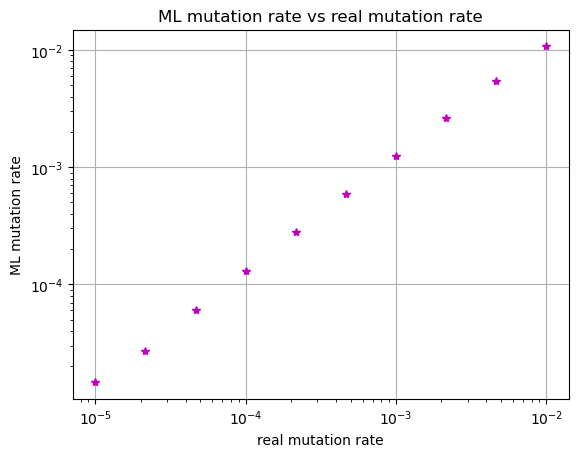

In [78]:
def pmf_spec_yule(end_time, initial_population, growth_rate, count):
    """
    The probability mass function (PMF) 
    for the Yule process
    
    Parameters:
    end_time: Total time for population growth
    initial_population: Starting population size
    growth_rate: Growth rate of the population
    count: Number of individuals in the population
    """
    return np.exp(growth_rate * end_time) * (1 - betainc(2, count, np.exp(- growth_rate * end_time)))/(count*(count+1)*(np.exp(growth_rate * end_time) - 1))
def pmf(end_time, initial_population, mu, growth_rate):
    """
    Compute the PMF using cumulative intensity
    
    Parameters:
    end_time: Total time for population growth  
    initial_population: Starting population size  
    mu: Mutation rate  
    growth_rate: Growth rate of the population  

    Returns:
    pmf_func: Probability mass function (PMF) for mutant population size
    """
    
    # Cumulative intensity function
    ci = cumulative_intensity(end_time, initial_population, mu, growth_rate)
    pmf_func = np.zeros(2000)
    pmf_func1 = np.zeros(2000)

    m = - ci
    pmf_func[0] = math.exp(m)
    for k in range(1, 2000):
        sum = 0
        for i in range(0, k):
            sum += ci * (k - i) / k * pmf_func[i] * pmf_spec_yule(end_time, initial_population, growth_rate, k - i)
        pmf_func[k] = sum
    return pmf_func

def log_likelihood(mu, data, end_time, initial_population, growth_rate, h):
    """
    Compute the log-likelihood for given mutation rate
    
    Parameters:
    mu: Mutation rate  
    data: Observed mutant population sizes  
    end_time: Total time for population growth  
    initial_population: Starting population size  
    growth_rate: Growth rate of the population  
    h: Histogram of mutant population counts  
   
    Returns:
    Negative log-likelihood for optimization  
    """

    pmf_func = pmf(end_time, initial_population,mu, growth_rate)
    pmf_func = np.maximum(pmf_func, 1e-10)
    likelihood = 0
    for k in data:
        if k < len(pmf_func):
            likelihood += h[k] * np.log(pmf_func[k] + 1e-10)  # Add epsilon to avoid log(0)
        else:
            likelihood += -np.inf  # Assign very low likelihood for out-of-range data
    print(-likelihood)
    return -likelihood  # Return negative for minimization

mutation_rate = [10 ** i for i in np.linspace(-2, -5, 10)]
num_simulations = 5000

mut_rate = np.zeros(len(mutation_rate))

for i in range(len(mutation_rate)):
    # run simulation for each mutation rate
    expected_mutant_population, variance_mutant_population, p0, expected_population, mutant_populations, final_populations = run_simulations(
        num_simulations, end_time, initial_population, growth_rate, mutation_rate[i])
    h = np.zeros(2000)
    
    for j in range(num_simulations):
        for q in range(len(h)):
            if q == mutant_populations[j]:
                h[q] += 1
    h_smooth = h[:2000] * num_simulations
  
    freq_m = gaussian_filter1d(h_smooth, sigma=0.45)

    data = range(2000)
    
    # Choose initial guess
    mu_initial = 10 ** (-5)

    # Perform MLE using scipy.optimize.minimize
    result = minimize(
       lambda log_mu: log_likelihood(np.exp(log_mu), data, end_time, initial_population, growth_rate, freq_m),
       x0=[np.log(mu_initial)],
       bounds=[(np.log(1e-10), np.log(1))],  
       method='L-BFGS-B'
       )
    mut_rate[i] = np.exp(result.x[0])

plt.plot(mutation_rate, mut_rate,'m*')
plt.title("ML mutation rate vs real mutation rate")
plt.ylabel("ML mutation rate")
plt.xlabel("real mutation rate")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

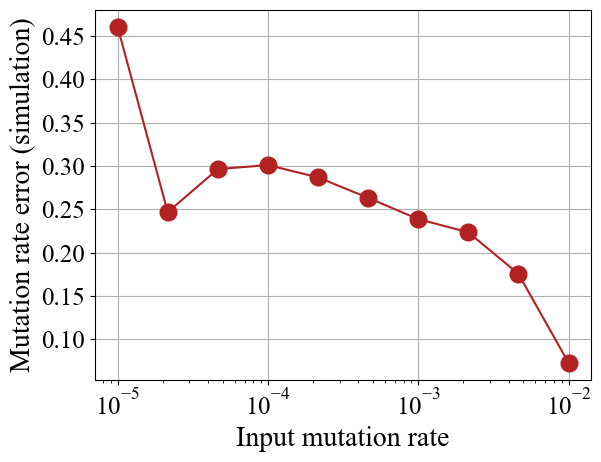

In [79]:
plt.plot(mutation_rate, abs(mut_rate-mutation_rate)/np.array(mutation_rate),'o-',markersize =12,color='firebrick')
plt.ylabel("Mutation rate error (simulation)", fontname='Times New Roman', fontsize=20)
plt.xlabel("Input mutation rate", fontname='Times New Roman', fontsize=20)
plt.xscale('log')
plt.xticks(fontsize=18, fontname="Times New Roman")
plt.yticks(fontsize=18, fontname="Times New Roman")
plt.grid(True)
plt.savefig("ML_relative_error_plot.svg", format='svg')